In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Загрузка DataFrame из файла
with open(r'./datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

In [6]:
df['Crystal'] = Crystal
df = df.loc[((df['Crystal'] != 'Ag') & (df['Crystal'] != 'Au') & (df['Crystal'] != 'B4C') & (df['Crystal'] != 'H2O_ice_1h') & (df['Crystal'] != 'Hg') & (df['Crystal'] != 'Li')& (df['Crystal'] != 'LiF')& (df['Crystal'] != 'Gd'))]
#df = df.loc[((df['Stats'] != Cr[0]) & (df['Stats'] != Cr[1]))]
df = df.reset_index(drop= True)
df

Matrix Crystal        Stats  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   10000000.0   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   10000000.0   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   10000000.0   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   10000000.0   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   10000000.0   
...                                                 ...     ...          ...   
3595  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3  500000000.0   
3596  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3  500000000.0   
3597  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3  500000000.0   
3598  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3  500000000.0   
3599  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3  500000000.0   

      Pulce duration  
0          10.000000  
1          25.263158  
2          40.526316  
3          55.789474  
4          71.052632  
...              ...  
3595      238.947368  
3596      254.210526  
3597      269.473684  
3598      284.736842  
3599      300.000000  

[3600 rows x 4 columns]

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Пример модели U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.decoder1 = self.up_conv(512, 256)
        self.decoder2 = self.up_conv(256, 128)
        self.decoder3 = self.up_conv(128, 64)
        self.decoder4 = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, 2))
        e3 = self.encoder3(F.max_pool2d(e2, 2))
        e4 = self.encoder4(F.max_pool2d(e3, 2))

        # Decoder
        d1 = self.decoder1(F.interpolate(e4, scale_factor=1, mode='bilinear', align_corners=True))
        d2 = self.decoder2(F.interpolate(d1 + e3, scale_factor=1, mode='bilinear', align_corners=True))
        d2 = F.pad(d2, (0, 0, 1, 0))  # (left, right, top, bottom)
        d3 = self.decoder3(F.interpolate(d2 + e2, scale_factor=1, mode='bilinear', align_corners=True))
        d4 = self.decoder4(F.interpolate(d3 + e1, scale_factor=1, mode='bilinear', align_corners=True))

        return torch.sigmoid(d4)

In [8]:
first_filter = UNet().to(device)

first_filter.load_state_dict(torch.load(r'model_weights_withoutBeam_unique.pth'))

<All keys matched successfully>

In [9]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

matrices = np.array(df['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
tensor = torch.FloatTensor(matrices)
tensor = tensor.unsqueeze(1)

dataset = TensorDataset(tensor)

# Создание DataLoader для каждой выборки
loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [10]:
seg_maps_df = pd.DataFrame()

maps = []
for bach in loader:
    with torch.no_grad():
        diffraction = bach[0]
        diffraction = diffraction.to(device)
        mapp = first_filter(diffraction)
        maps.append(mapp[0][0].cpu().numpy())


seg_maps_df['Matrix'] = maps       
seg_maps_df['Crystal'] = df['Crystal']
seg_maps_df['Stats'] = df['Stats']
seg_maps_df['Pulce duration'] = df['Pulce duration']
#seg_maps_df.to_csv('KNN_validation_database_dt_distribution_append.csv', index=False)

In [11]:
len(maps)

3600

In [12]:
with open(r'seg_maps_dataset.pkl', 'wb') as f:
    pickle.dump(seg_maps_df, f)

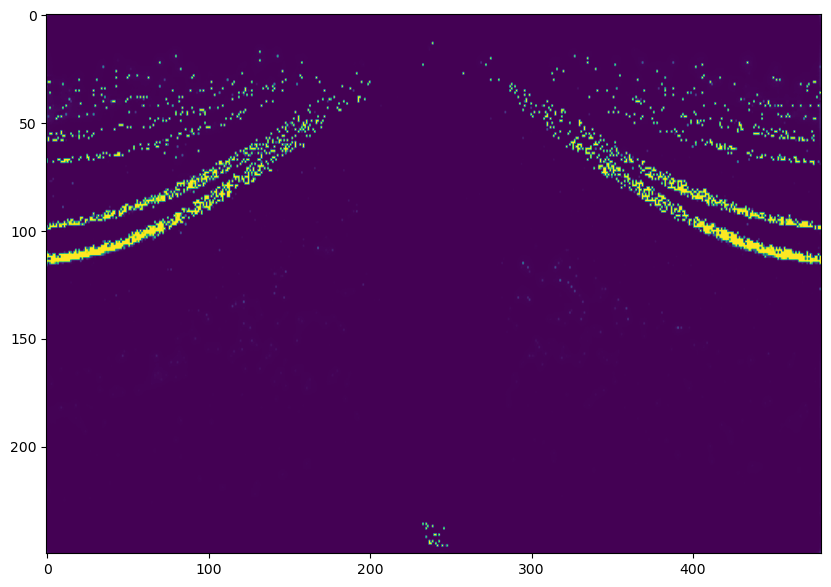

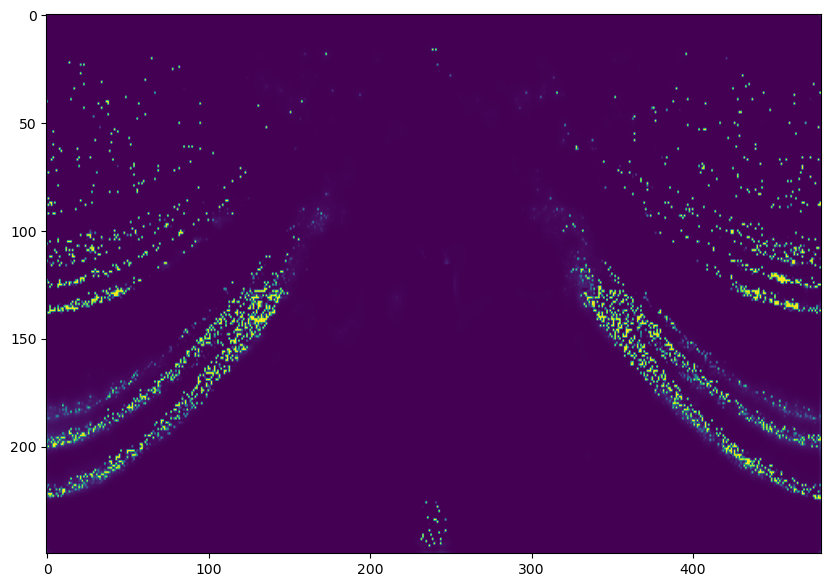

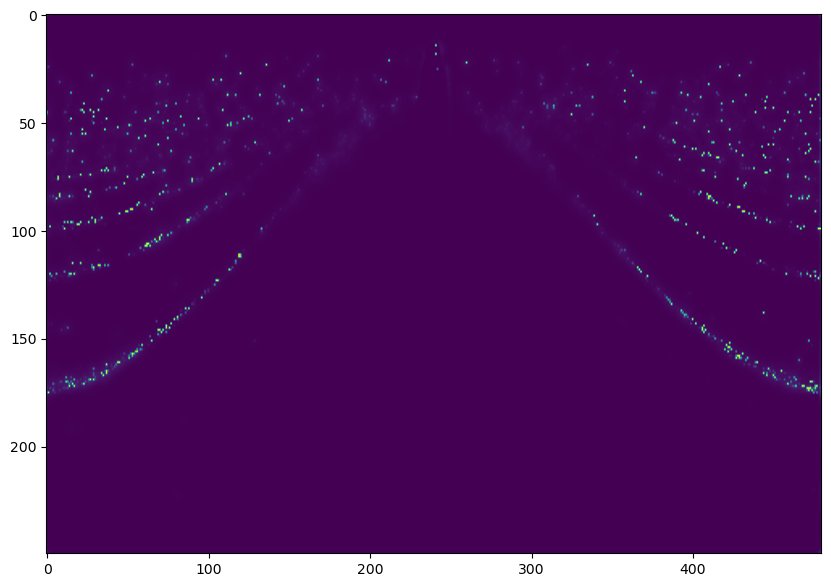

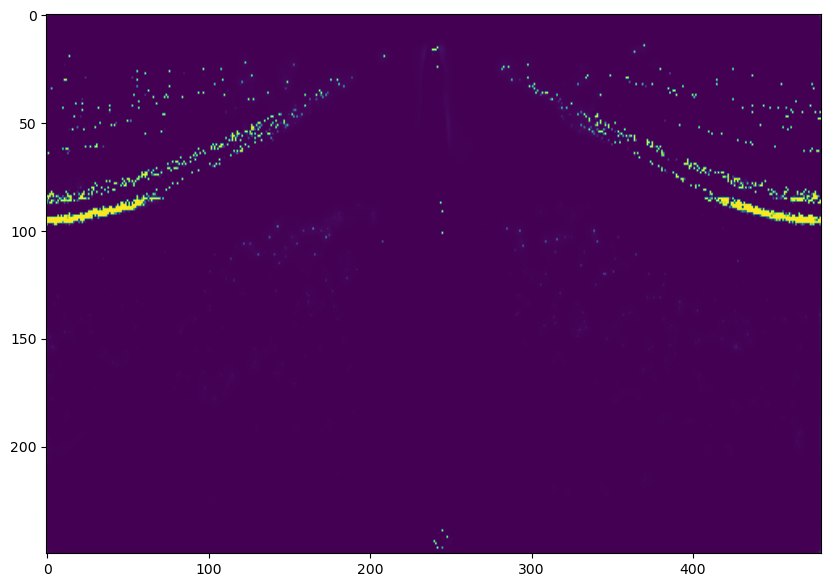

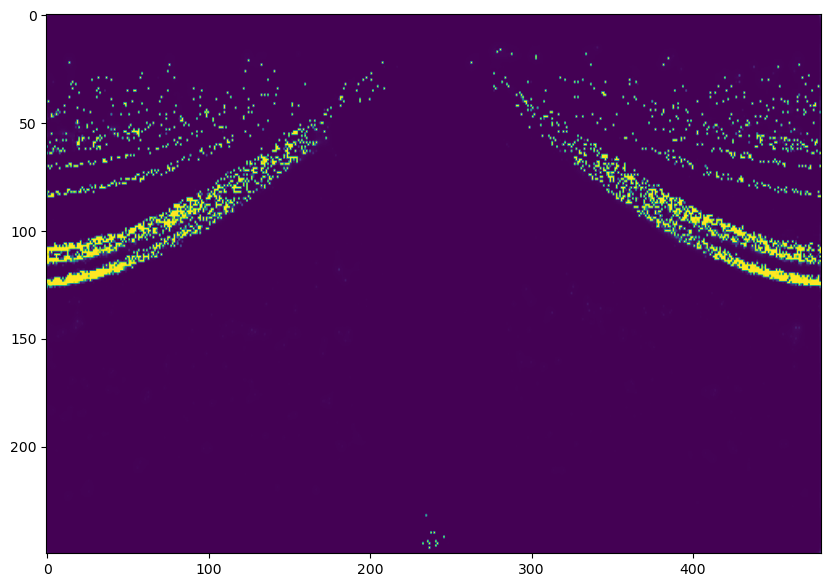

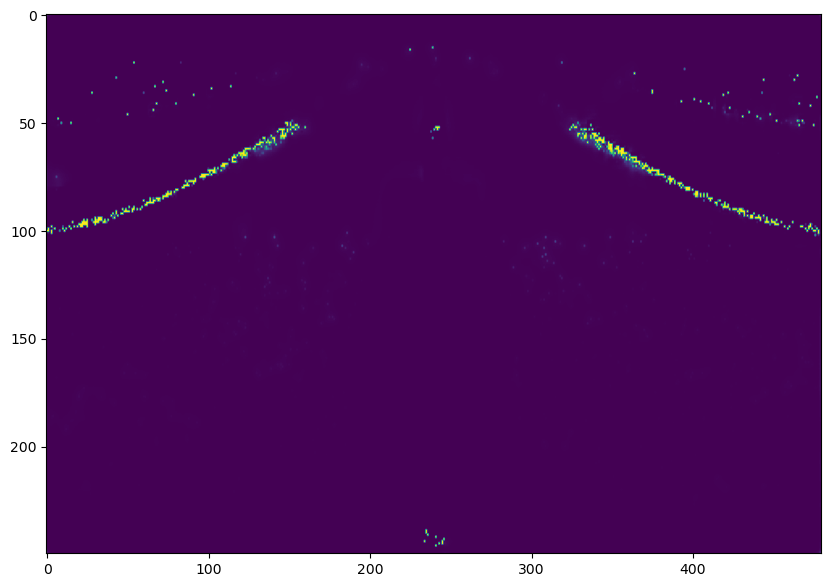

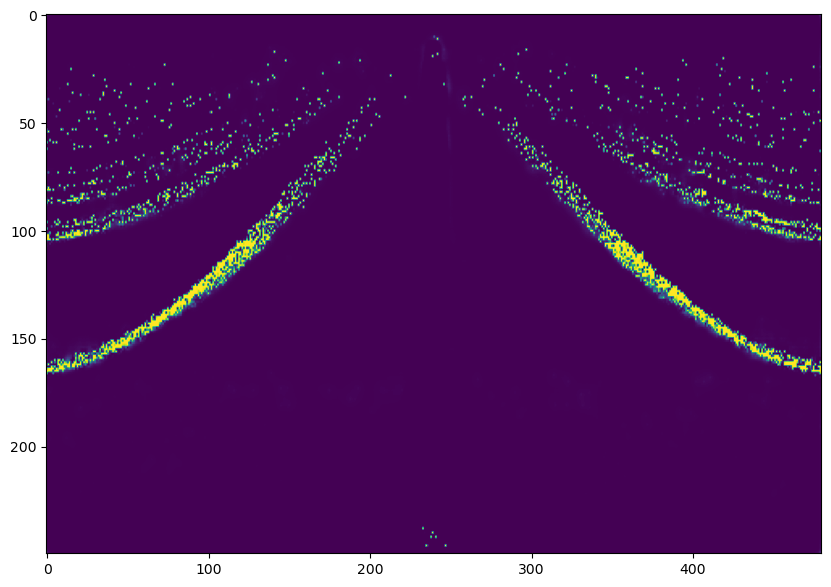

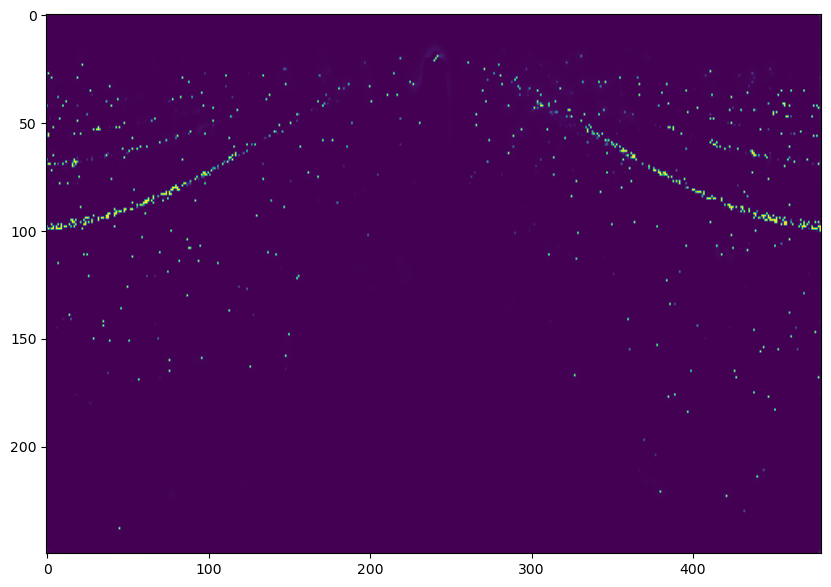

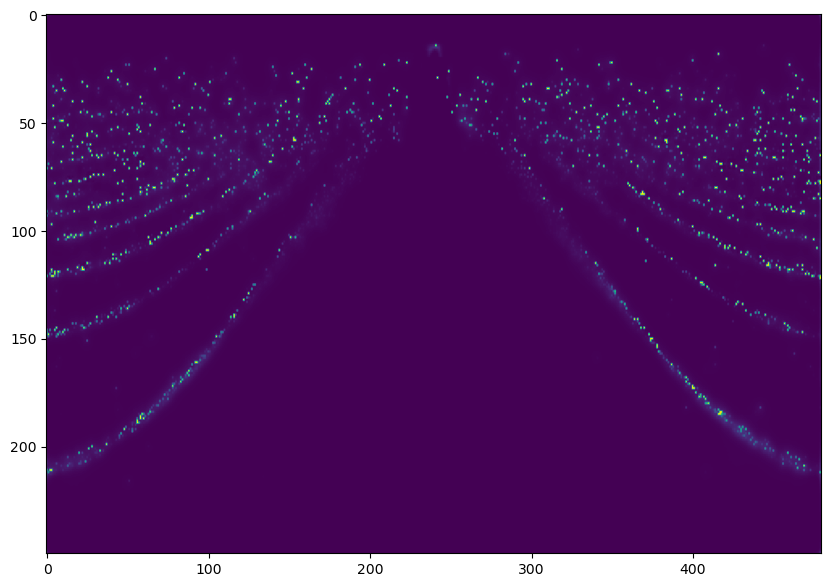

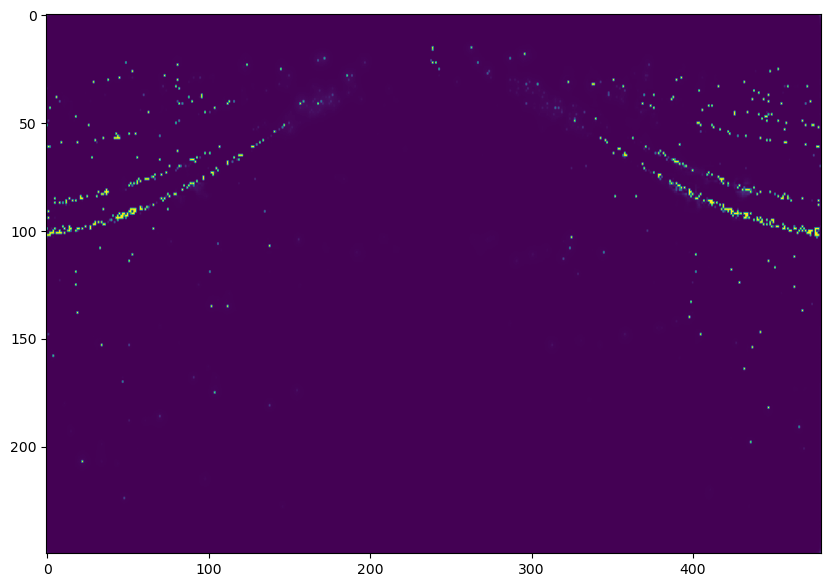

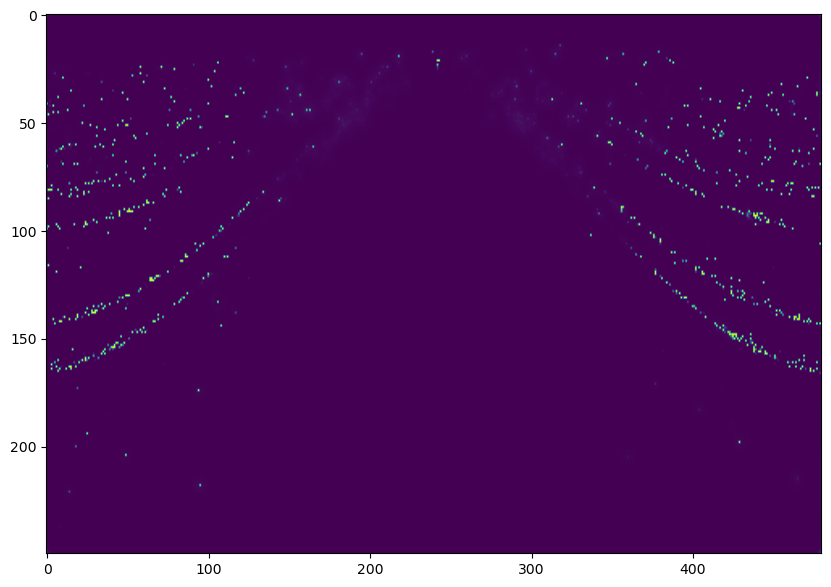

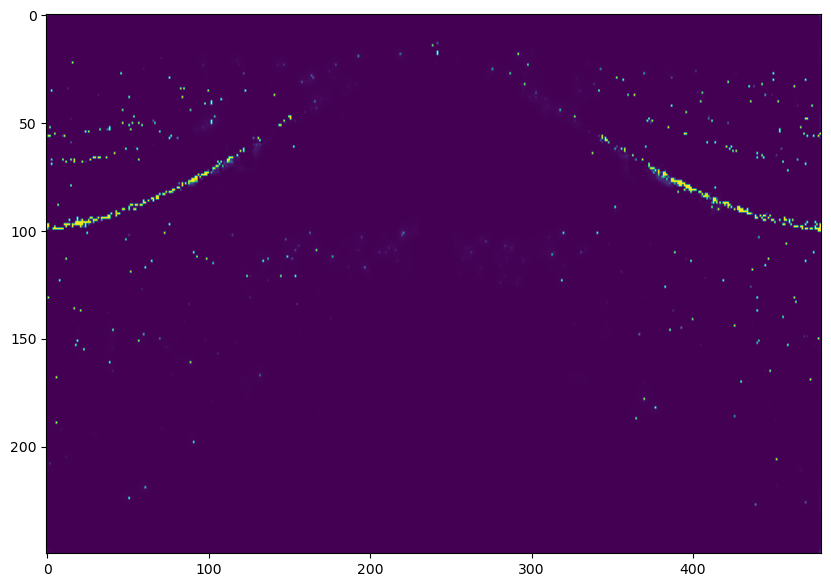

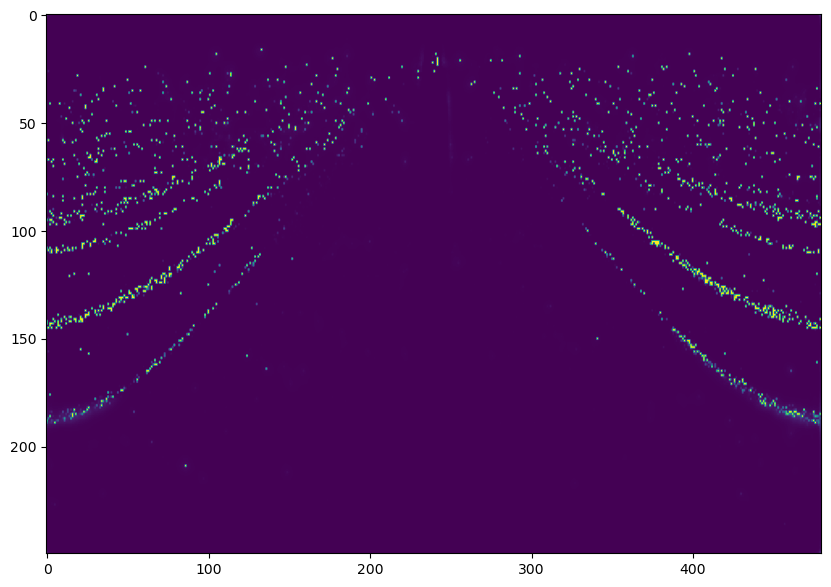

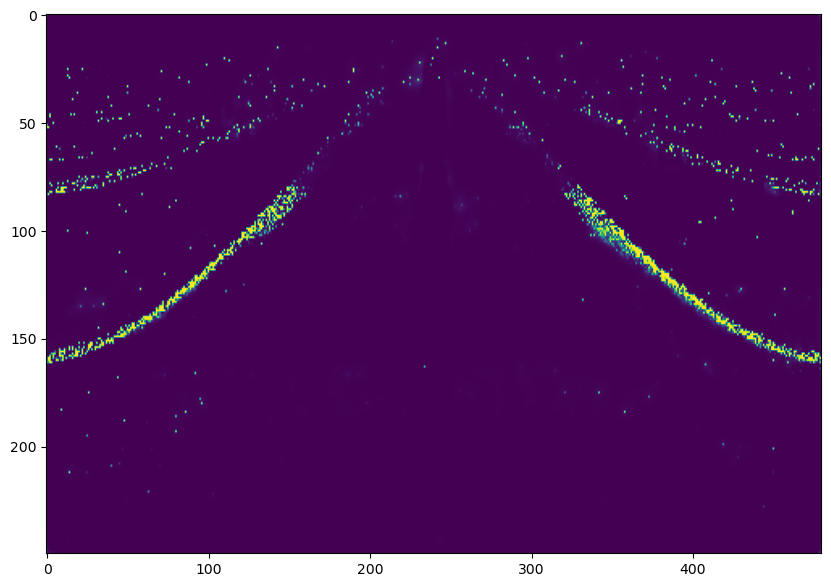

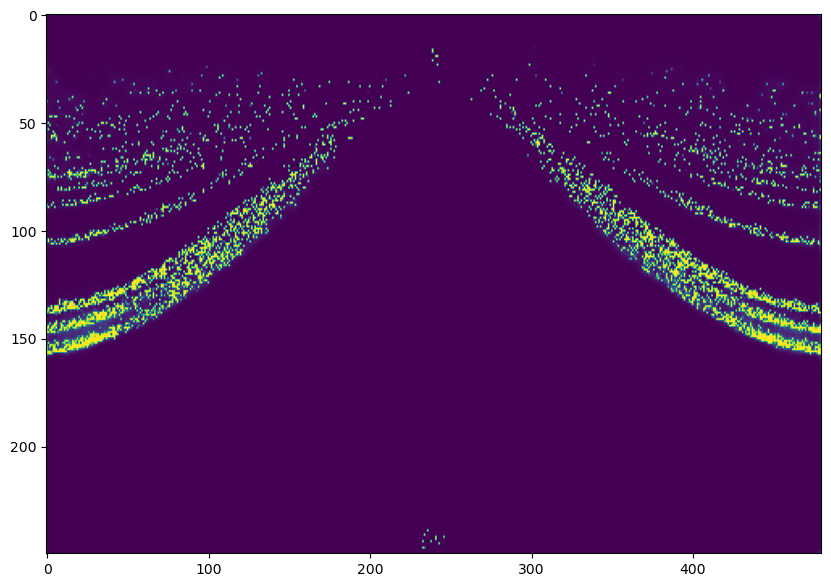

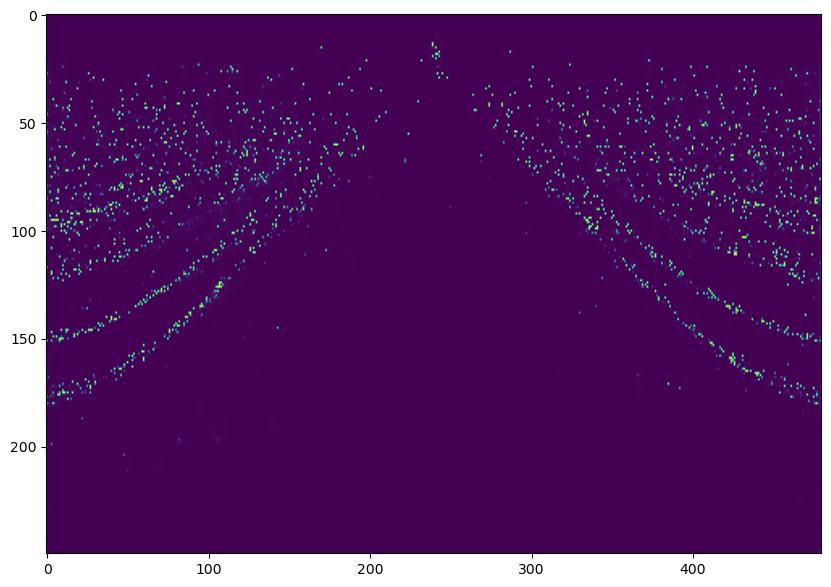

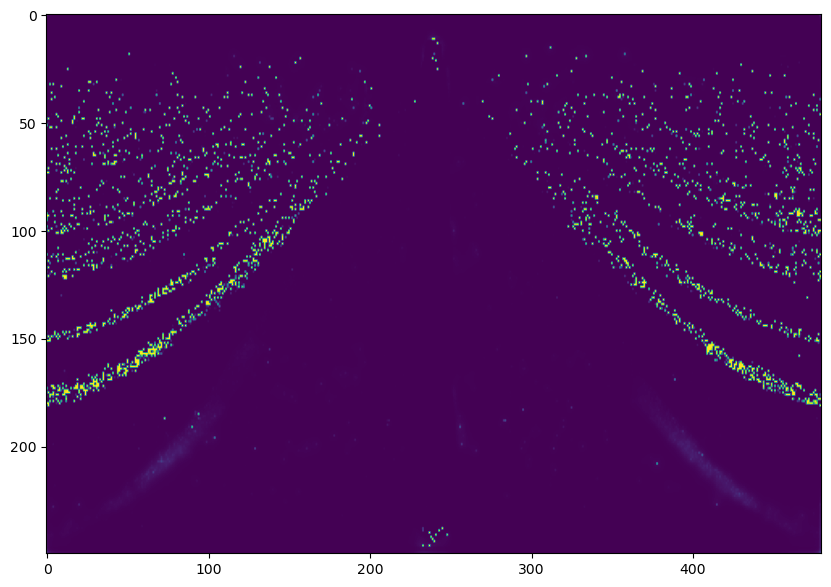

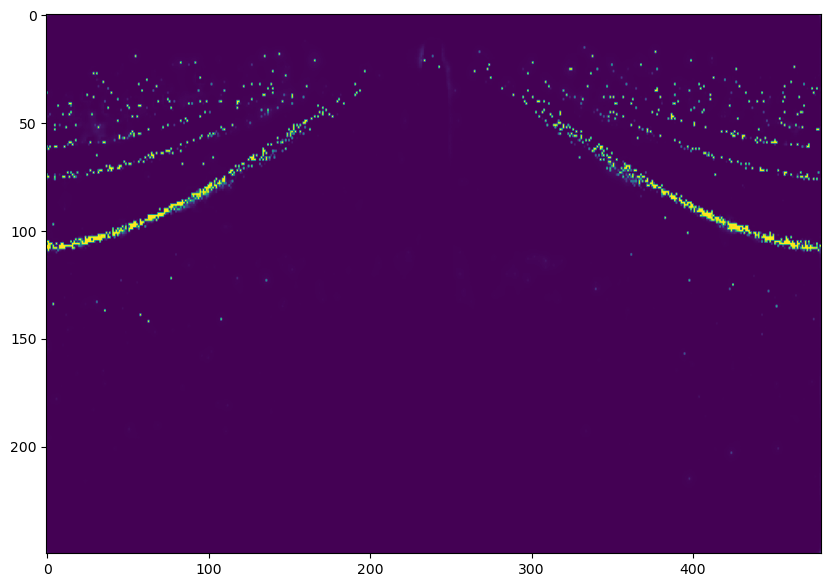

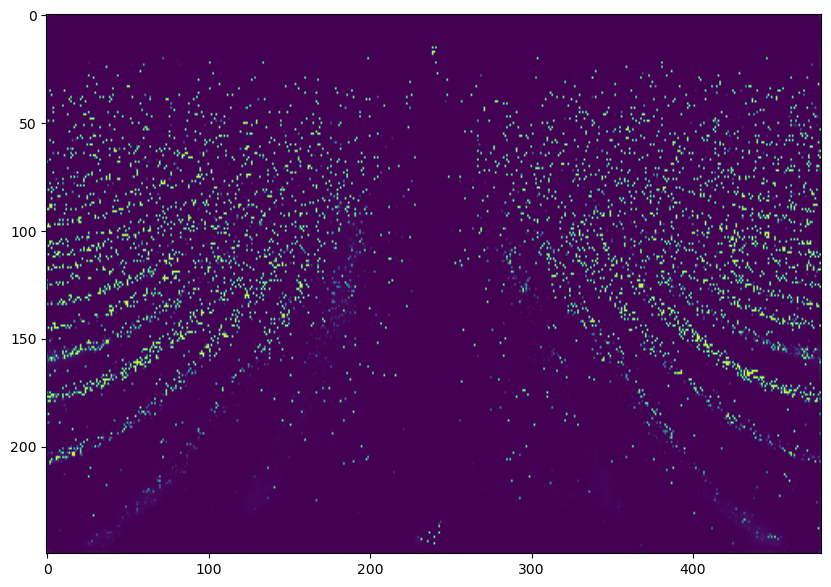

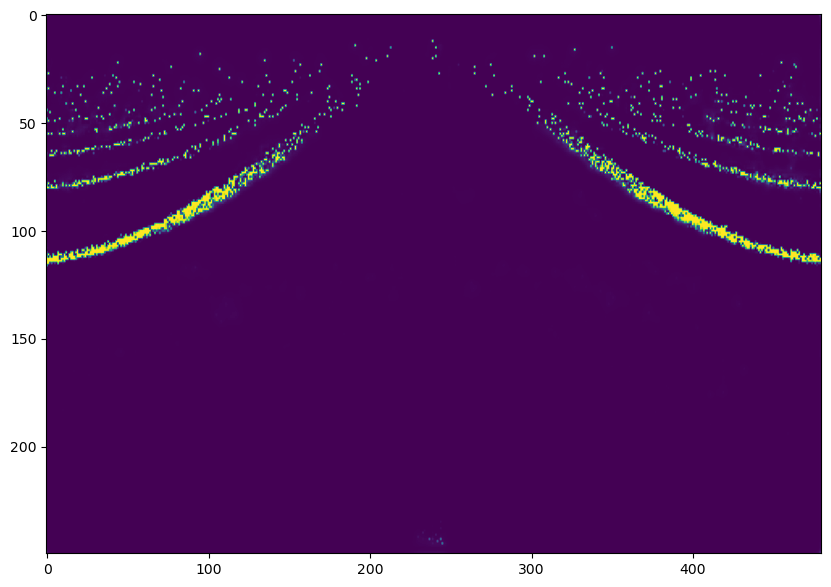

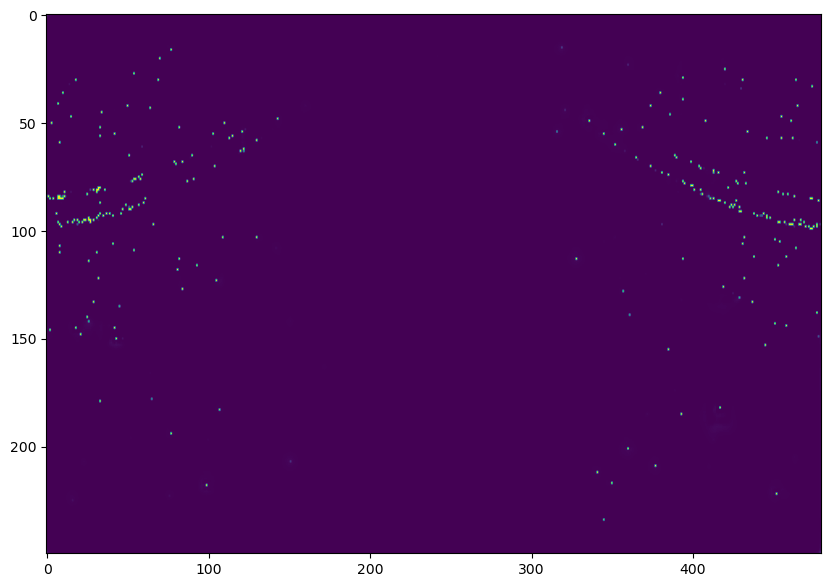

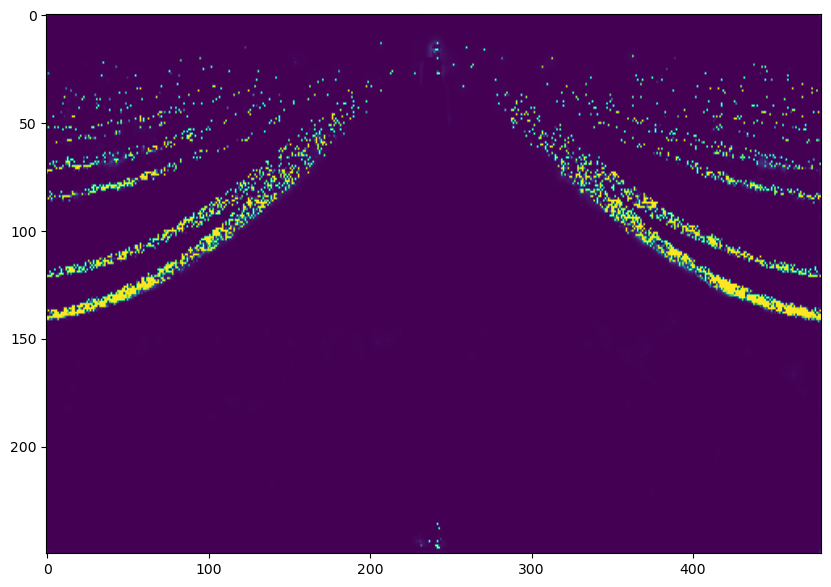

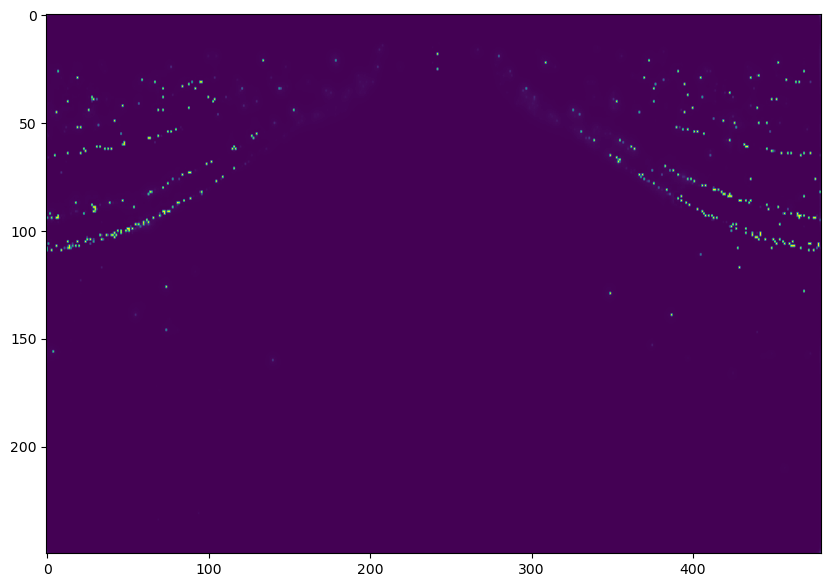

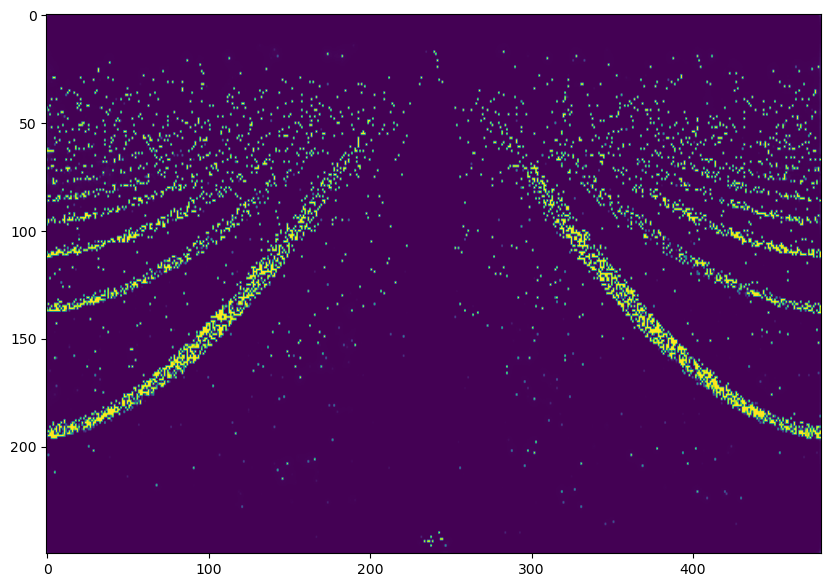

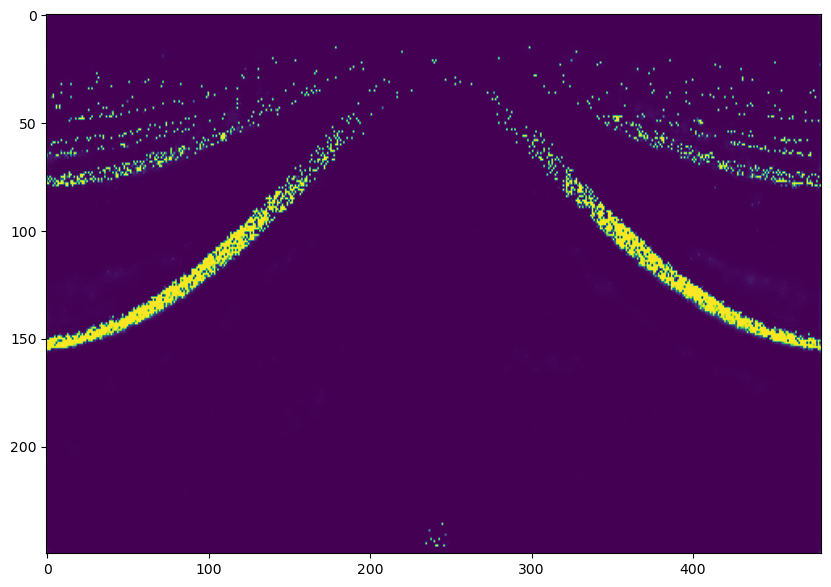

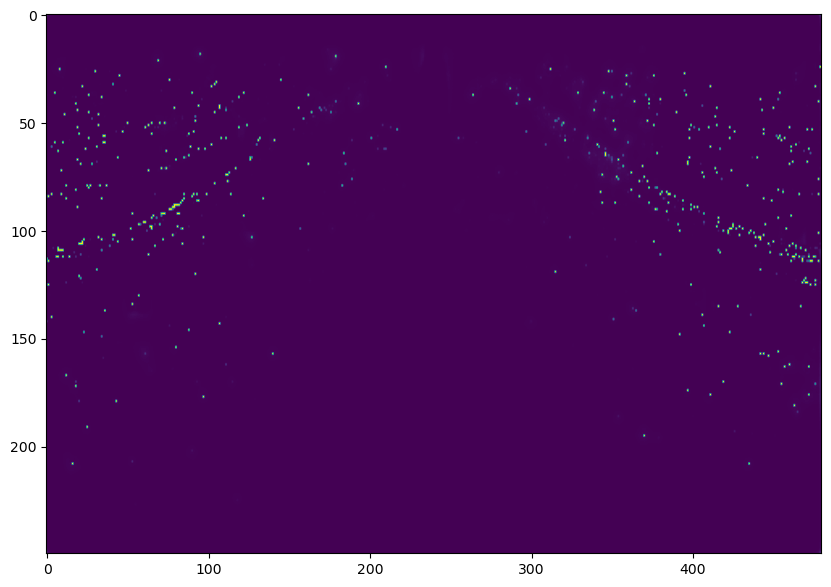

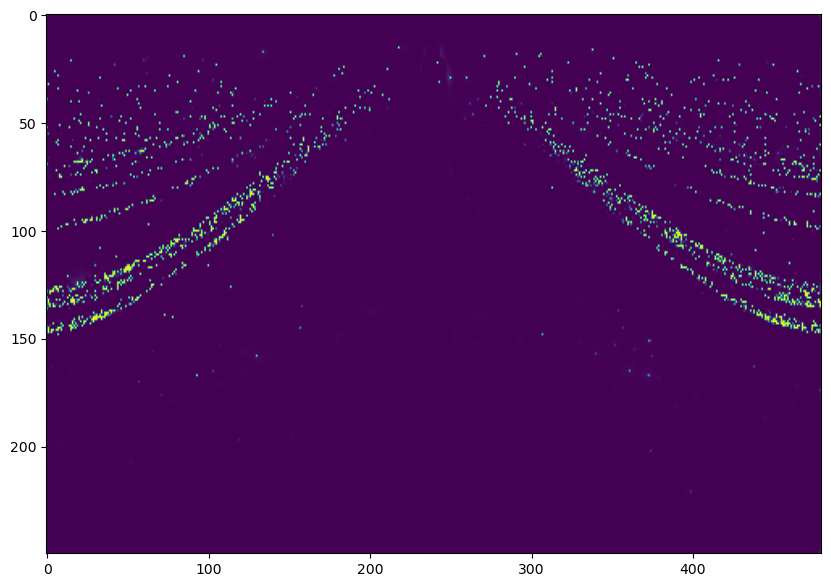

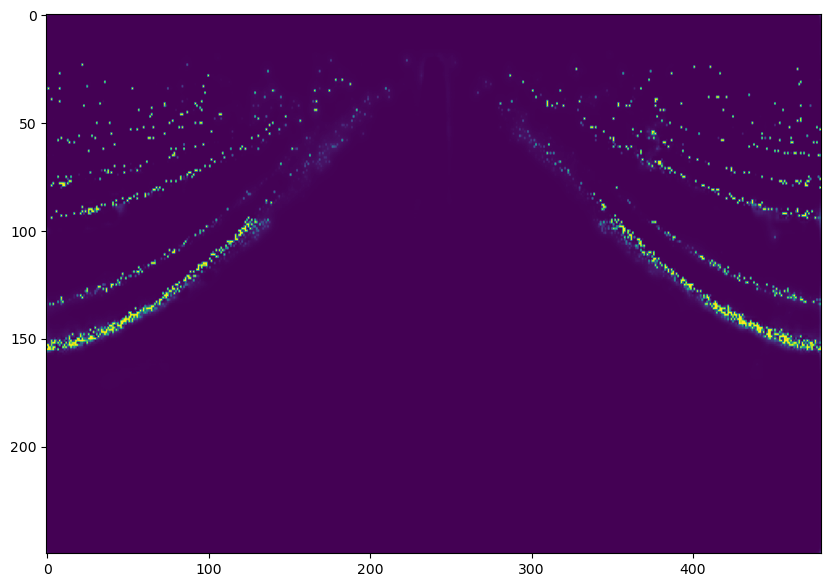

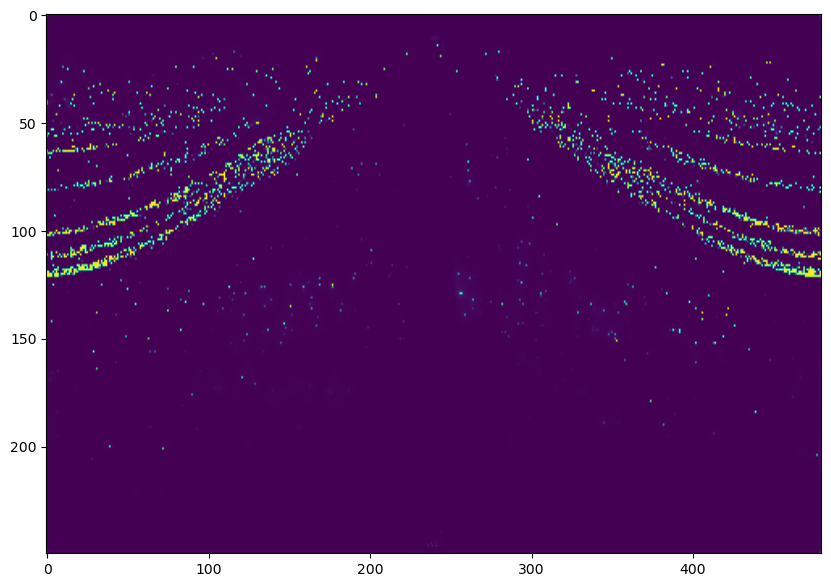

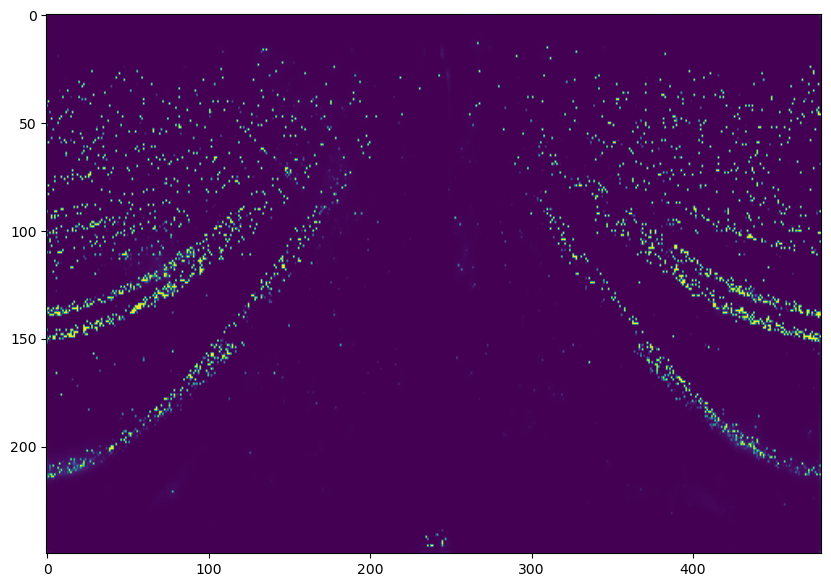

In [14]:
for i in range(len(maps)):
    plt.figure(figsize=(10,7))
    plt.imshow(maps[i], cmap='viridis', aspect='auto')
    plt.show()